## Imports

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('Churn.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.shape

(10000, 14)

In [5]:
df.duplicated().sum()

0

In [6]:
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

## Análise Exploratória de Dados (EDA)

In [7]:
# Verificando se o mesmo ID aparece em mais de uma linha
df[df.duplicated(subset='CustomerId', keep=False)]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [8]:
# Verificando se a RowNumber aparece em mais de uma linha
df[df.duplicated(subset='RowNumber', keep=False)]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


Aqui verifiquei essas colunas para ver se não havia repetição dessas colunas em mais de uma linha para fazer a remoção delas com mais segurança.

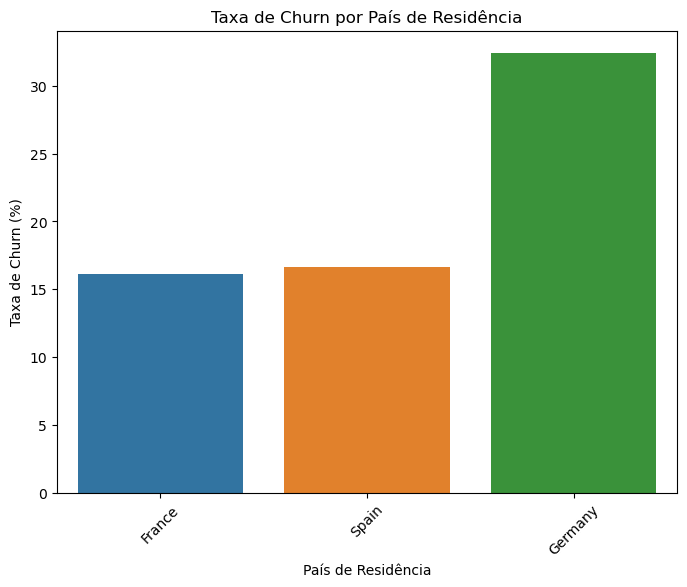

In [9]:
# Calcule a taxa de churn por país
churn_by_geography = df.groupby('Geography')['Exited'].mean().sort_values() * 100

# Plot da taxa de churn por país
plt.figure(figsize=(8, 6))
sns.barplot(x=churn_by_geography.index, y=churn_by_geography.values)
plt.xlabel('País de Residência')
plt.ylabel('Taxa de Churn (%)')
plt.title('Taxa de Churn por País de Residência')
plt.xticks(rotation=45)
plt.show()

**Observamos que os clientes que residem na França e na Espanha possuem taxas churn semelhantes, entorno de 15%, se diferenciando da Alemanha que possui uma taxa de churn um pouco maior que 30%**

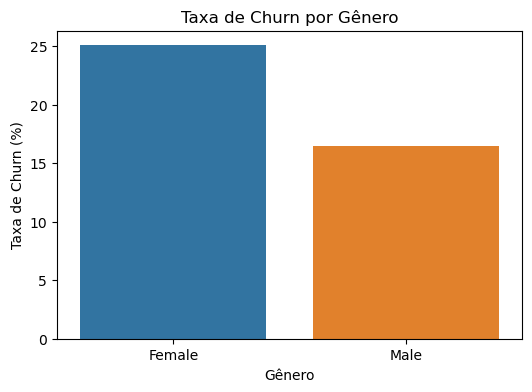

In [10]:
# Calcule a taxa de churn por gênero
churn_by_gender = df.groupby('Gender')['Exited'].mean() * 100

# Plot da taxa de churn por gênero
plt.figure(figsize=(6, 4))
sns.barplot(x=churn_by_gender.index, y=churn_by_gender.values)
plt.xlabel('Gênero')
plt.ylabel('Taxa de Churn (%)')
plt.title('Taxa de Churn por Gênero')
plt.show()

In [11]:
df['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

**Observamos aqui que os clientes do sexo feminino possui uma taxa de churn maior que do sexo masculino, essa diferença está entorno de 8 a 10%**

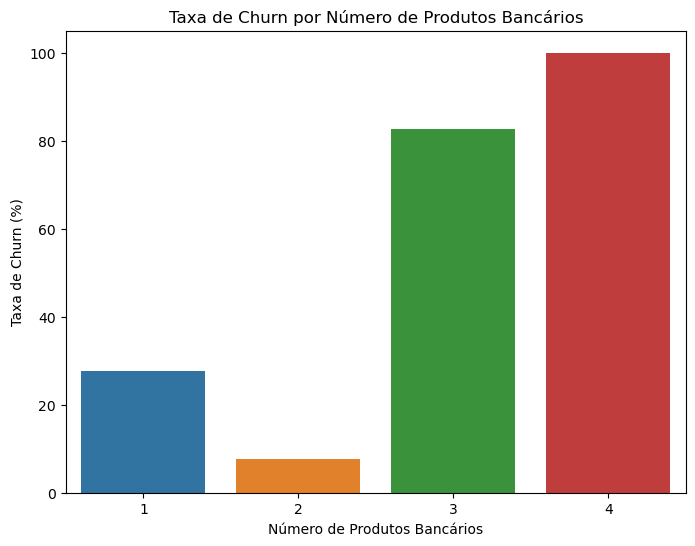

In [12]:
# Calcule a taxa de churn por número de produtos bancários
churn_by_num_of_products = df.groupby('NumOfProducts')['Exited'].mean() * 100

# Plot da taxa de churn por número de produtos bancários
plt.figure(figsize=(8, 6))
sns.barplot(x=churn_by_num_of_products.index, y=churn_by_num_of_products.values)
plt.xlabel('Número de Produtos Bancários')
plt.ylabel('Taxa de Churn (%)')
plt.title('Taxa de Churn por Número de Produtos Bancários')
plt.show()

In [13]:
df['NumOfProducts'].value_counts()

NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64

**Interessante, clientes que usaram 3 produtos bancarios tiverem uma taxa de churn de 80%, as que usaram 4 tem uma taxa de churn de 100%. Se for do interesse da empresa caberia uma analise mais detalhada sobre o perfil desses clientes para entender mais a fundo o porque dessa taxa de churn tão alta.**

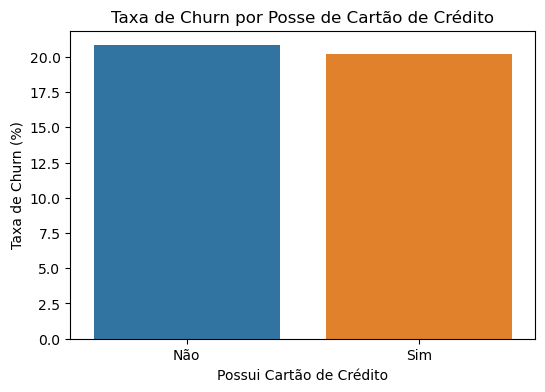

In [14]:
# Calcule a taxa de churn por posse de cartão de crédito
churn_by_has_cr_card = df.groupby('HasCrCard')['Exited'].mean() * 100

# Plot da taxa de churn por posse de cartão de crédito
plt.figure(figsize=(6, 4))
sns.barplot(x=churn_by_has_cr_card.index, y=churn_by_has_cr_card.values)
plt.xlabel('Possui Cartão de Crédito')
plt.ylabel('Taxa de Churn (%)')
plt.title('Taxa de Churn por Posse de Cartão de Crédito')
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.show()

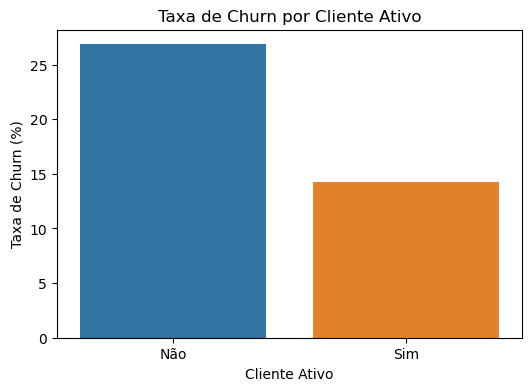

In [15]:
# Calcule a taxa de churn por cliente ativo
churn_by_is_active_member = df.groupby('IsActiveMember')['Exited'].mean() * 100

# Plot da taxa de churn por cliente ativo
plt.figure(figsize=(6, 4))
sns.barplot(x=churn_by_is_active_member.index, y=churn_by_is_active_member.values)
plt.xlabel('Cliente Ativo')
plt.ylabel('Taxa de Churn (%)')
plt.title('Taxa de Churn por Cliente Ativo')
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.show()

**Observamos aqui que clientes não ativos possuem uma taxa maior de churn do que clientes ativos, entorno de 10 a 13% a mais**

C:\Users\DANIEL\AppData\Local\Temp\ipykernel_824\89875980.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_age_bins = df.groupby('Age_bins')['Exited'].mean() * 100
C:\Users\DANIEL\anaconda3\envs\DatScience\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


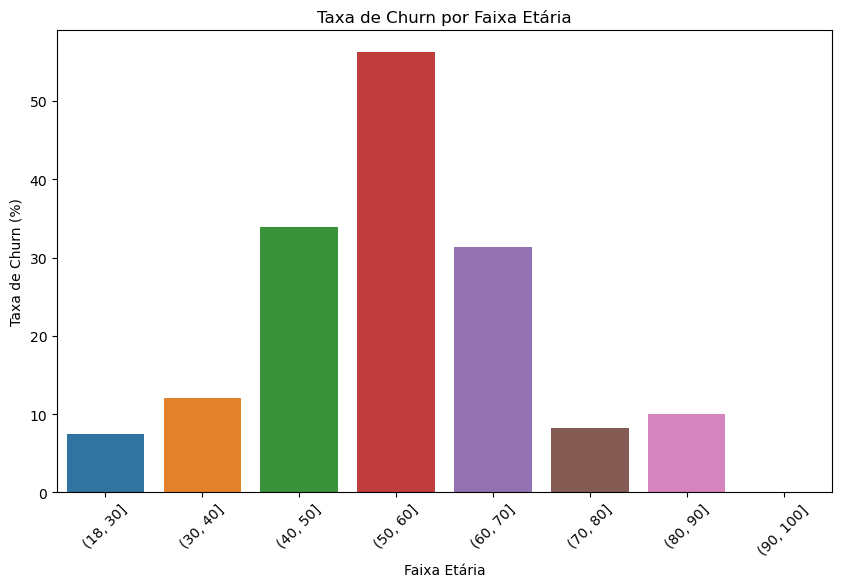

In [16]:
# Defina faixas etárias para agrupar as idades
age_bins = [18, 30, 40, 50, 60, 70, 80, 90, 100]

# Crie faixas de idades e calcule a taxa de churn por faixa etária
df['Age_bins'] = pd.cut(df['Age'], bins=age_bins)
churn_by_age_bins = df.groupby('Age_bins')['Exited'].mean() * 100

# Plot da taxa de churn por faixa etária
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_by_age_bins.index, y=churn_by_age_bins.values)
plt.xlabel('Faixa Etária')
plt.ylabel('Taxa de Churn (%)')
plt.title('Taxa de Churn por Faixa Etária')
plt.xticks(rotation=45)
plt.show()

**Observamos aqui que as pessoas com maior taxa com base em sua idade, são pessoas entre os 50 a 60 anos, com aproximadamente 55% de churn. As idades 40 a 50 possuem aproximadamente 35% e as de 60 a 70 aproximadamente 32%. Observamos tambem que há uma grande distancia da taxa de churn fora desses intervalos de idade, com taxas de churn bem menores.**

C:\Users\DANIEL\AppData\Local\Temp\ipykernel_824\1219808156.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_credit_score_bins = df.groupby('CreditScore_bins')['Exited'].mean() * 100
C:\Users\DANIEL\anaconda3\envs\DatScience\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


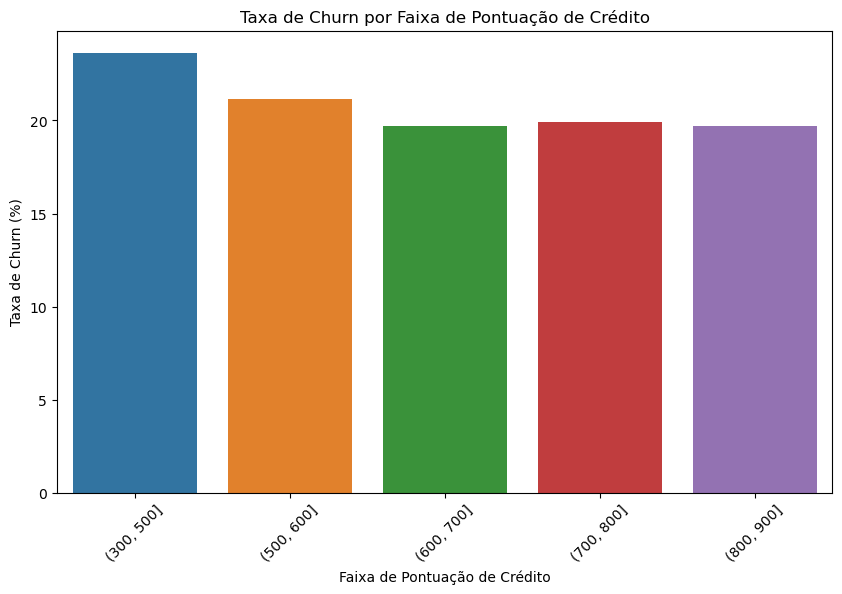

In [17]:
# Defina faixas de pontuação de crédito para agrupar as pontuações
credit_score_bins = [300, 500, 600, 700, 800, 900]

# Crie faixas de pontuação de crédito e calcule a taxa de churn por faixa de pontuação
df['CreditScore_bins'] = pd.cut(df['CreditScore'], bins=credit_score_bins)
churn_by_credit_score_bins = df.groupby('CreditScore_bins')['Exited'].mean() * 100

# Plot da taxa de churn por faixa de pontuação de crédito
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_by_credit_score_bins.index, y=churn_by_credit_score_bins.values)
plt.xlabel('Faixa de Pontuação de Crédito')
plt.ylabel('Taxa de Churn (%)')
plt.title('Taxa de Churn por Faixa de Pontuação de Crédito')
plt.xticks(rotation=45)
plt.show()

**Observamos aqui que não há uma grande disparidade nas taxas de churn por pontuação de credito entre os clientes que possuem de 600 a 900 de pontuação. Os clientes entre 500 e 600 possuem uma taxa de churn um pouco maior e os de 300 a 500 tambem um pouco maior, mas não mais que aproximadamente 5%.**

C:\Users\DANIEL\AppData\Local\Temp\ipykernel_824\157391446.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_balance_bins = df.groupby('Balance_bins')['Exited'].mean() * 100
C:\Users\DANIEL\anaconda3\envs\DatScience\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


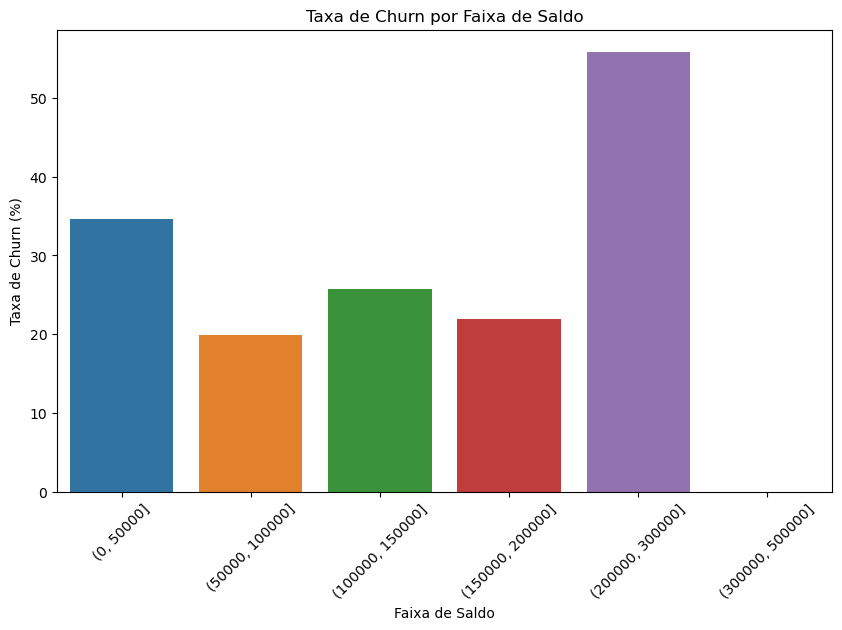

In [18]:
# Defina faixas de saldo para agrupar os saldos
balance_bins = [0, 50000, 100000, 150000, 200000, 300000, 500000]

# Crie faixas de saldo e calcule a taxa de churn por faixa de saldo
df['Balance_bins'] = pd.cut(df['Balance'], bins=balance_bins)
churn_by_balance_bins = df.groupby('Balance_bins')['Exited'].mean() * 100

# Plot da taxa de churn por faixa de saldo
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_by_balance_bins.index, y=churn_by_balance_bins.values)
plt.xlabel('Faixa de Saldo')
plt.ylabel('Taxa de Churn (%)')
plt.title('Taxa de Churn por Faixa de Saldo')
plt.xticks(rotation=45)
plt.show()

In [19]:
# Defina as faixas de saldo com menos grupos
balance_bins = [0, 50000, 100000, 150000, 200000, 300000, 500000]

# Crie a coluna 'Balance_bins' com base nas novas faixas de saldo
df['Balance_bins'] = pd.cut(df['Balance'], bins=balance_bins)

# Use value_counts para contar as ocorrências em cada faixa de saldo
balance_counts = df['Balance_bins'].value_counts()

print(balance_counts)

Balance_bins
(100000, 150000]    3830
(50000, 100000]     1509
(150000, 200000]     935
(0, 50000]            75
(200000, 300000]      34
(300000, 500000]       0
Name: count, dtype: int64


**Vizualizamos aqui mais diferenças nas taxas de churn em relação ao saldo na conta dos clientes, mas acho que tomar conclusões apenas por esse gráfico e o value_counts poderia ser um erro. Se for do interesse da empresa, caberia uma análise mais detalhada do perfil das pessoas com base em seu saldo bancario**

C:\Users\DANIEL\anaconda3\envs\DatScience\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DANIEL\anaconda3\envs\DatScience\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


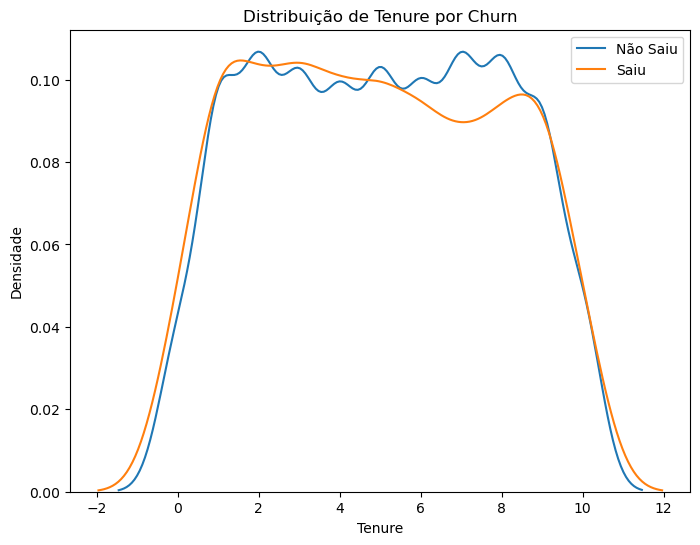

In [20]:
# Carregue seus dados em um DataFrame df
# ...

plt.figure(figsize=(8, 6))
sns.kdeplot(df[df['Exited'] == 0]['Tenure'], label='Não Saiu')
sns.kdeplot(df[df['Exited'] == 1]['Tenure'], label='Saiu')
plt.xlabel('Tenure')
plt.ylabel('Densidade')
plt.title('Distribuição de Tenure por Churn')
plt.legend()
plt.show()

**Aparentemente quanto mais tempo o cliente permanece com o banco, menor é a 'chance' dele sair.**

## Pré-processamento de Dados

In [21]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_bins,CreditScore_bins,Balance_bins
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,"(40, 50]","(600, 700]",NaN
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,"(40, 50]","(600, 700]","(50000.0, 100000.0]"
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,"(40, 50]","(500, 600]","(150000.0, 200000.0]"
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,"(30, 40]","(600, 700]",NaN
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,"(40, 50]","(800, 900]","(100000.0, 150000.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0,"(30, 40]","(700, 800]",NaN
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0,"(30, 40]","(500, 600]","(50000.0, 100000.0]"
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1,"(30, 40]","(700, 800]",NaN
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1,"(40, 50]","(700, 800]","(50000.0, 100000.0]"


In [22]:
# Remove as colunas especificadas
columns_to_remove = ['RowNumber', 'CustomerId', 'Surname', 'Age_bins', 'CreditScore_bins', 'Balance_bins']
df = df.drop(columns=columns_to_remove)

In [23]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [24]:
# Remove os valores nulos da coluna 'Tenure'
df = df.dropna(subset=['Tenure'])

# Reset o índice
df = df.reset_index(drop=True)

In [25]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9086,800,France,Female,29,2.0,0.00,2,0,0,167773.55,0
9087,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9088,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9089,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1


In [26]:
# Identifique as colunas categóricas que deseja codificar
categorical_columns = ['Geography', 'Gender']

# Aplica o One-Hot Encoding nas colunas categóricas
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

## Divisão de Dados

In [27]:
df_encoded

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1.0,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8.0,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1.0,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2.0,125510.82,1,1,1,79084.10,0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
9086,800,29,2.0,0.00,2,0,0,167773.55,0,False,False,False
9087,771,39,5.0,0.00,2,1,0,96270.64,0,False,False,True
9088,516,35,10.0,57369.61,1,1,1,101699.77,0,False,False,True
9089,709,36,7.0,0.00,1,0,1,42085.58,1,False,False,False


In [28]:
X = df_encoded.drop('Exited', axis=1)
y = df_encoded['Exited']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

### RandomForestClassifier

In [30]:
rf_model = RandomForestClassifier(random_state=6)

In [31]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=6)

In [32]:
rf_predict = rf_model.predict(X_test)

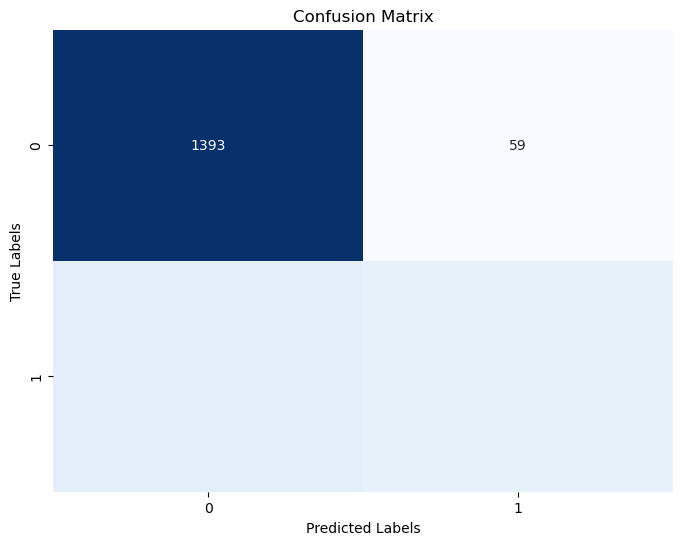

In [33]:
# Calcula a matriz de confusão
conf_matrix = confusion_matrix(y_test, rf_predict)

# Cria uma figura para exibir a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [34]:
# Calcula o relatório de classificação
report = classification_report(y_test, rf_predict)

# Exibe o relatório
print(report)

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1452
           1       0.74      0.46      0.57       367

    accuracy                           0.86      1819
   macro avg       0.81      0.71      0.74      1819
weighted avg       0.85      0.86      0.84      1819



Contagem de Classes:
Exited
0    7237
1    1854
Name: count, dtype: int64

Proporção de Classes:
Exited
0    0.796062
1    0.203938
Name: count, dtype: float64


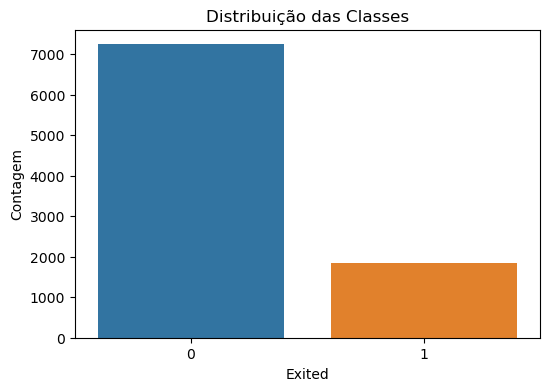

In [35]:
# Calcule a contagem de cada classe na coluna 'Exited'
class_counts = df['Exited'].value_counts()

# Calcule a proporção de cada classe em relação ao total de exemplos
class_proportions = class_counts / len(df)

# Exiba as contagens e proporções das classes
print("Contagem de Classes:")
print(class_counts)
print("\nProporção de Classes:")
print(class_proportions)

# Plote um gráfico de barras para visualizar a distribuição das classes
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Exited')
plt.xlabel('Exited')
plt.ylabel('Contagem')
plt.title('Distribuição das Classes')
plt.show()

In [36]:
# Fazer previsões das probabilidades de classe 1
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# Calcular a métrica AUC-ROC
roc_auc = roc_auc_score(y_test, rf_probs)

# Imprimir o valor da métrica AUC-ROC
print("AUC-ROC:", roc_auc)

AUC-ROC: 0.8638756277163508


#### RandomForestClassifier + GridSearchCV

In [37]:
# Definir os valores a serem testados para cada hiperparâmetro
param_grid = {
    'n_estimators': [50, 100, 150],
    'class_weight': [None, 'balanced'],
    'max_depth': [None, 10, 20, 30]
}


In [38]:
# Criar o modelo RandomForestClassifier com hiperparâmetros padrão
GSrf_model = RandomForestClassifier(random_state=6)

# Definir os valores a serem testados para cada hiperparâmetro
param_grid = {
    'n_estimators': [50, 100, 150],
    'class_weight': [None, 'balanced'],
    'max_depth': [None, 10, 20, 30]
}

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(estimator=GSrf_model, param_grid=param_grid, cv=5, scoring='f1')

# Treinar o modelo usando GridSearchCV
grid_search.fit(X_train, y_train)

# Melhores hiperparâmetros encontrados
best_params = grid_search.best_params_
print("Melhores Hiperparâmetros:", best_params)

# Fazer previsões com o melhor modelo encontrado
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calcular e imprimir o relatório de classificação
report = classification_report(y_test, y_pred)
print(report)

Melhores Hiperparâmetros: {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1452
           1       0.62      0.64      0.63       367

    accuracy                           0.85      1819
   macro avg       0.76      0.77      0.77      1819
weighted avg       0.85      0.85      0.85      1819



In [39]:
# Fazer previsões das probabilidades de classe 1
GSrf_probs = best_model.predict_proba(X_test)[:, 1]

# Calcular a métrica AUC-ROC
roc_auc = roc_auc_score(y_test, GSrf_probs)

# Imprimir o valor da métrica AUC-ROC
print("AUC-ROC:", roc_auc)

AUC-ROC: 0.8671924846683331


### BalancedRandomForest

In [40]:
# Ignorar FutureWarning relacionado a 'sampling_strategy' no BalancedRandomForestClassifier
warnings.filterwarnings("ignore", category=FutureWarning, module="imblearn")

In [41]:
# Criar o modelo BalancedRandomForest
brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=6)

# Treinar o modelo
brf_model.fit(X_train, y_train)

# Fazer previsões
brf_pred = brf_model.predict(X_test)

# Calcular e imprimir o relatório de classificação
report = classification_report(y_test, brf_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.81      0.86      1452
           1       0.50      0.76      0.60       367

    accuracy                           0.80      1819
   macro avg       0.71      0.78      0.73      1819
weighted avg       0.84      0.80      0.81      1819



In [42]:
# Fazer previsões das probabilidades de classe 1
brf_probs = brf_model.predict_proba(X_test)[:, 1]

# Calcular a métrica AUC-ROC
roc_auc = roc_auc_score(y_test, brf_probs)

# Imprimir o valor da métrica AUC-ROC
print("AUC-ROC:", roc_auc)

AUC-ROC: 0.8644920845812597


#### BalancedRandomForest + GridSearchCV

In [43]:
# Criar o modelo BalancedRandomForestClassifier
GSbrf_model = BalancedRandomForestClassifier(random_state=6)

# Definir os valores a serem testados para cada hiperparâmetro
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy']
}

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(estimator=GSbrf_model, param_grid=param_grid, cv=5, scoring='f1')

# Treinar o modelo usando GridSearchCV
grid_search.fit(X_train, y_train)

# Melhores hiperparâmetros encontrados
best_params = grid_search.best_params_
print("Melhores Hiperparâmetros:", best_params)

# Fazer previsões com o melhor modelo encontrado
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calcular e imprimir o relatório de classificação
report = classification_report(y_test, y_pred)
print(report)

Melhores Hiperparâmetros: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 150}
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1452
           1       0.51      0.77      0.62       367

    accuracy                           0.81      1819
   macro avg       0.72      0.79      0.74      1819
weighted avg       0.85      0.81      0.82      1819



In [44]:
# Fazer previsões das probabilidades de classe 1
GSbrf_probs = best_model.predict_proba(X_test)[:, 1]

# Calcular a métrica AUC-ROC
roc_auc = roc_auc_score(y_test, GSbrf_probs)

# Imprimir o valor da métrica AUC-ROC
print("AUC-ROC:", roc_auc)

AUC-ROC: 0.8693843312991194


### LightGBM

In [45]:
lgbm_model = lgb.LGBMClassifier( scale_pos_weight = 4,random_state=6)

lgbm_model.fit(X_train, y_train)

lgbm_pred = lgbm_model.predict(X_test)

report = classification_report(y_test, lgbm_pred)
print(report)

[LightGBM] [Info] Number of positive: 1487, number of negative: 5785
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 7272, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.204483 -> initscore=-1.358508
[LightGBM] [Info] Start training from score -1.358508
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1452
           1       0.54      0.72      0.62       367

    accuracy                           0.82      1819
   macro avg       0.73      0.78      0.75      1819
weighted avg       0.85      0.82      0.83      1819



In [46]:
# Fazer previsões das probabilidades de classe 1
lgbm_probs = lgbm_model.predict_proba(X_test)[:, 1]

# Calcular a métrica AUC-ROC
roc_auc = roc_auc_score(y_test, lgbm_probs)

# Imprimir o valor da métrica AUC-ROC
print("AUC-ROC:", roc_auc)

AUC-ROC: 0.8585545822355334


#### LightGBM + GridSearchCV

In [47]:
# Criar o modelo LGBMClassifier
GSlgbm_model = lgb.LGBMClassifier(scale_pos_weight = 4,random_state=6)

# Definir os valores a serem testados para cada hiperparâmetro
param_grid = {
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_samples': [10, 20, 30]
}

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(estimator=GSlgbm_model, param_grid=param_grid, cv=5, scoring='f1')

# Treinar o modelo usando GridSearchCV
grid_search.fit(X_train, y_train)

# Melhores hiperparâmetros encontrados
best_params = grid_search.best_params_
print("Melhores Hiperparâmetros:", best_params)

# Fazer previsões com o melhor modelo encontrado
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calcular e imprimir o relatório de classificação
report = classification_report(y_test, y_pred)
print(report)

[LightGBM] [Info] Number of positive: 1189, number of negative: 4628
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 5817, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.204401 -> initscore=-1.359012
[LightGBM] [Info] Start training from score -1.359012
[LightGBM] [Info] Number of positive: 1189, number of negative: 4628
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 5817, number of used features: 11
[LightGBM] [Info] [binary:

In [48]:
# Fazer previsões das probabilidades de classe 1
GSlgbm_probs = best_model.predict_proba(X_test)[:, 1]

# Calcular a métrica AUC-ROC
roc_auc = roc_auc_score(y_test, GSlgbm_probs)

# Imprimir o valor da métrica AUC-ROC
print("AUC-ROC:", roc_auc)

AUC-ROC: 0.85929395515722


### SVM

In [49]:
# Padronizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
# Criar o modelo SVM
model = SVC(random_state=6)

In [51]:
# Treinar o modelo
model.fit(X_train_scaled, y_train)

SVC(random_state=6)

In [52]:
# Fazer previsões
y_pred = model.predict(X_test_scaled)

In [53]:
# Calcular e imprimir o relatório de classificação
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.98      0.91      1452
           1       0.80      0.36      0.50       367

    accuracy                           0.85      1819
   macro avg       0.83      0.67      0.70      1819
weighted avg       0.85      0.85      0.83      1819



# Conclusão

O modelo com maior precisão e maior escore F1 foi o RandomForestClassifier com o uso do GridSearchCV para ajustar alguns hiperparâmetros. Seus valores são de 85% de acurácia, um F1-score de 0.63 e uma taxa de 83.6% no AUC-ROC. Em minha opinião, este modelo é o mais apropriado para fazer previsões de possíveis churns (cancelamentos).